# Sarcasm detection in Reddit comments

In this project we will try to predict sarcasm in Reddit comments. We will work with the following balanced [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm), which is a processed version of the dataset used in the paper by
Khodak, Saunshi and Vodrahalli, entitled "A Large Self-Annotated Corpus for Sarcasm". The dataset contains more than a million Reddit comments, each labeled either sarcastic or sincere (by users themselves), along with some metadata.


##  Exploratory data analysis and preparation

First we import the necessary modules and load the data.

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,RandomizedSearchCV,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, roc_curve, classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix
import re
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk import ngrams
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
import string
from collections import defaultdict
from collections import Counter
from scipy.sparse import hstack

from xgboost import XGBClassifier

color = sns.color_palette()
%config InlineBackend.figure_format = 'retina'

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly.subplots import make_subplots
pd.options.mode.chained_assignment = None

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
df = pd.read_csv('/kaggle/input/sarcasm/train-balanced-sarcasm.csv')

Let us expore the data.

In [4]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 1010826 entries, 0 to 1010825

Data columns (total 10 columns):

 #   Column          Non-Null Count    Dtype 

---  ------          --------------    ----- 

 0   label           1010826 non-null  int64 

 1   comment         1010773 non-null  object

 2   author          1010826 non-null  object

 3   subreddit       1010826 non-null  object

 4   score           1010826 non-null  int64 

 5   ups             1010826 non-null  int64 

 6   downs           1010826 non-null  int64 

 7   date            1010826 non-null  object

 8   created_utc     1010826 non-null  object

 9   parent_comment  1010826 non-null  object

dtypes: int64(4), object(6)

memory usage: 77.1+ MB


Make sure that the dataset is indeed balanced and drop the rows with empty comments.

In [17]:
df.dropna(subset=['comment'], inplace=True)
df['label'].value_counts()

label
0    505403
1    505368
Name: count, dtype: int64

Now let's do some preprocessing. However, before we convert all comments to lowercase, let us add another feature which will be the number of words written in uppercase. Then we drop columns which we will not use.

In [18]:
def preprocessing(s):
    s = str(s).lower().strip()
    s = re.sub('\n', '', s)
    s = re.sub(r"([?!,\":;\(\)])", r" \1 ", s)
    s = re.sub('[ ]{2,}', ' ', s).strip()
    return s

df['num_of_uppercase_words'] = df['comment'].apply(lambda x: sum(map(str.isupper, str(x).split())))
df['comment'] = df['comment'].apply(preprocessing)

In [19]:
df.drop(columns=['author','date','created_utc','parent_comment'], inplace=True)

Now let's look at some frequencies (frist individual words, then bigrams and trigrams). For this, we will exclude some meaningless words using the built-in list of stop words.

In [9]:
df1 = df[df['label']==1]
df0 = df[df['label']==0]

In [10]:
def create_n_grams(C,n=1,k=50):
    text = ' '.join(C)
    text = [i for i in text.split() if i not in stop_words and i not in string.punctuation]
    text_ngrams = [i for i in ngrams(text, n)]
    freq_dic = pd.DataFrame(Counter(text_ngrams).most_common(k))
    freq_dic.columns = ['word', 'wordcount']
    freq_dic.word = freq_dic.word.apply(lambda i: ' '.join(i))
    return freq_dic

Text(0.5, 1.0, 'Frequent words in sarcastic comments')

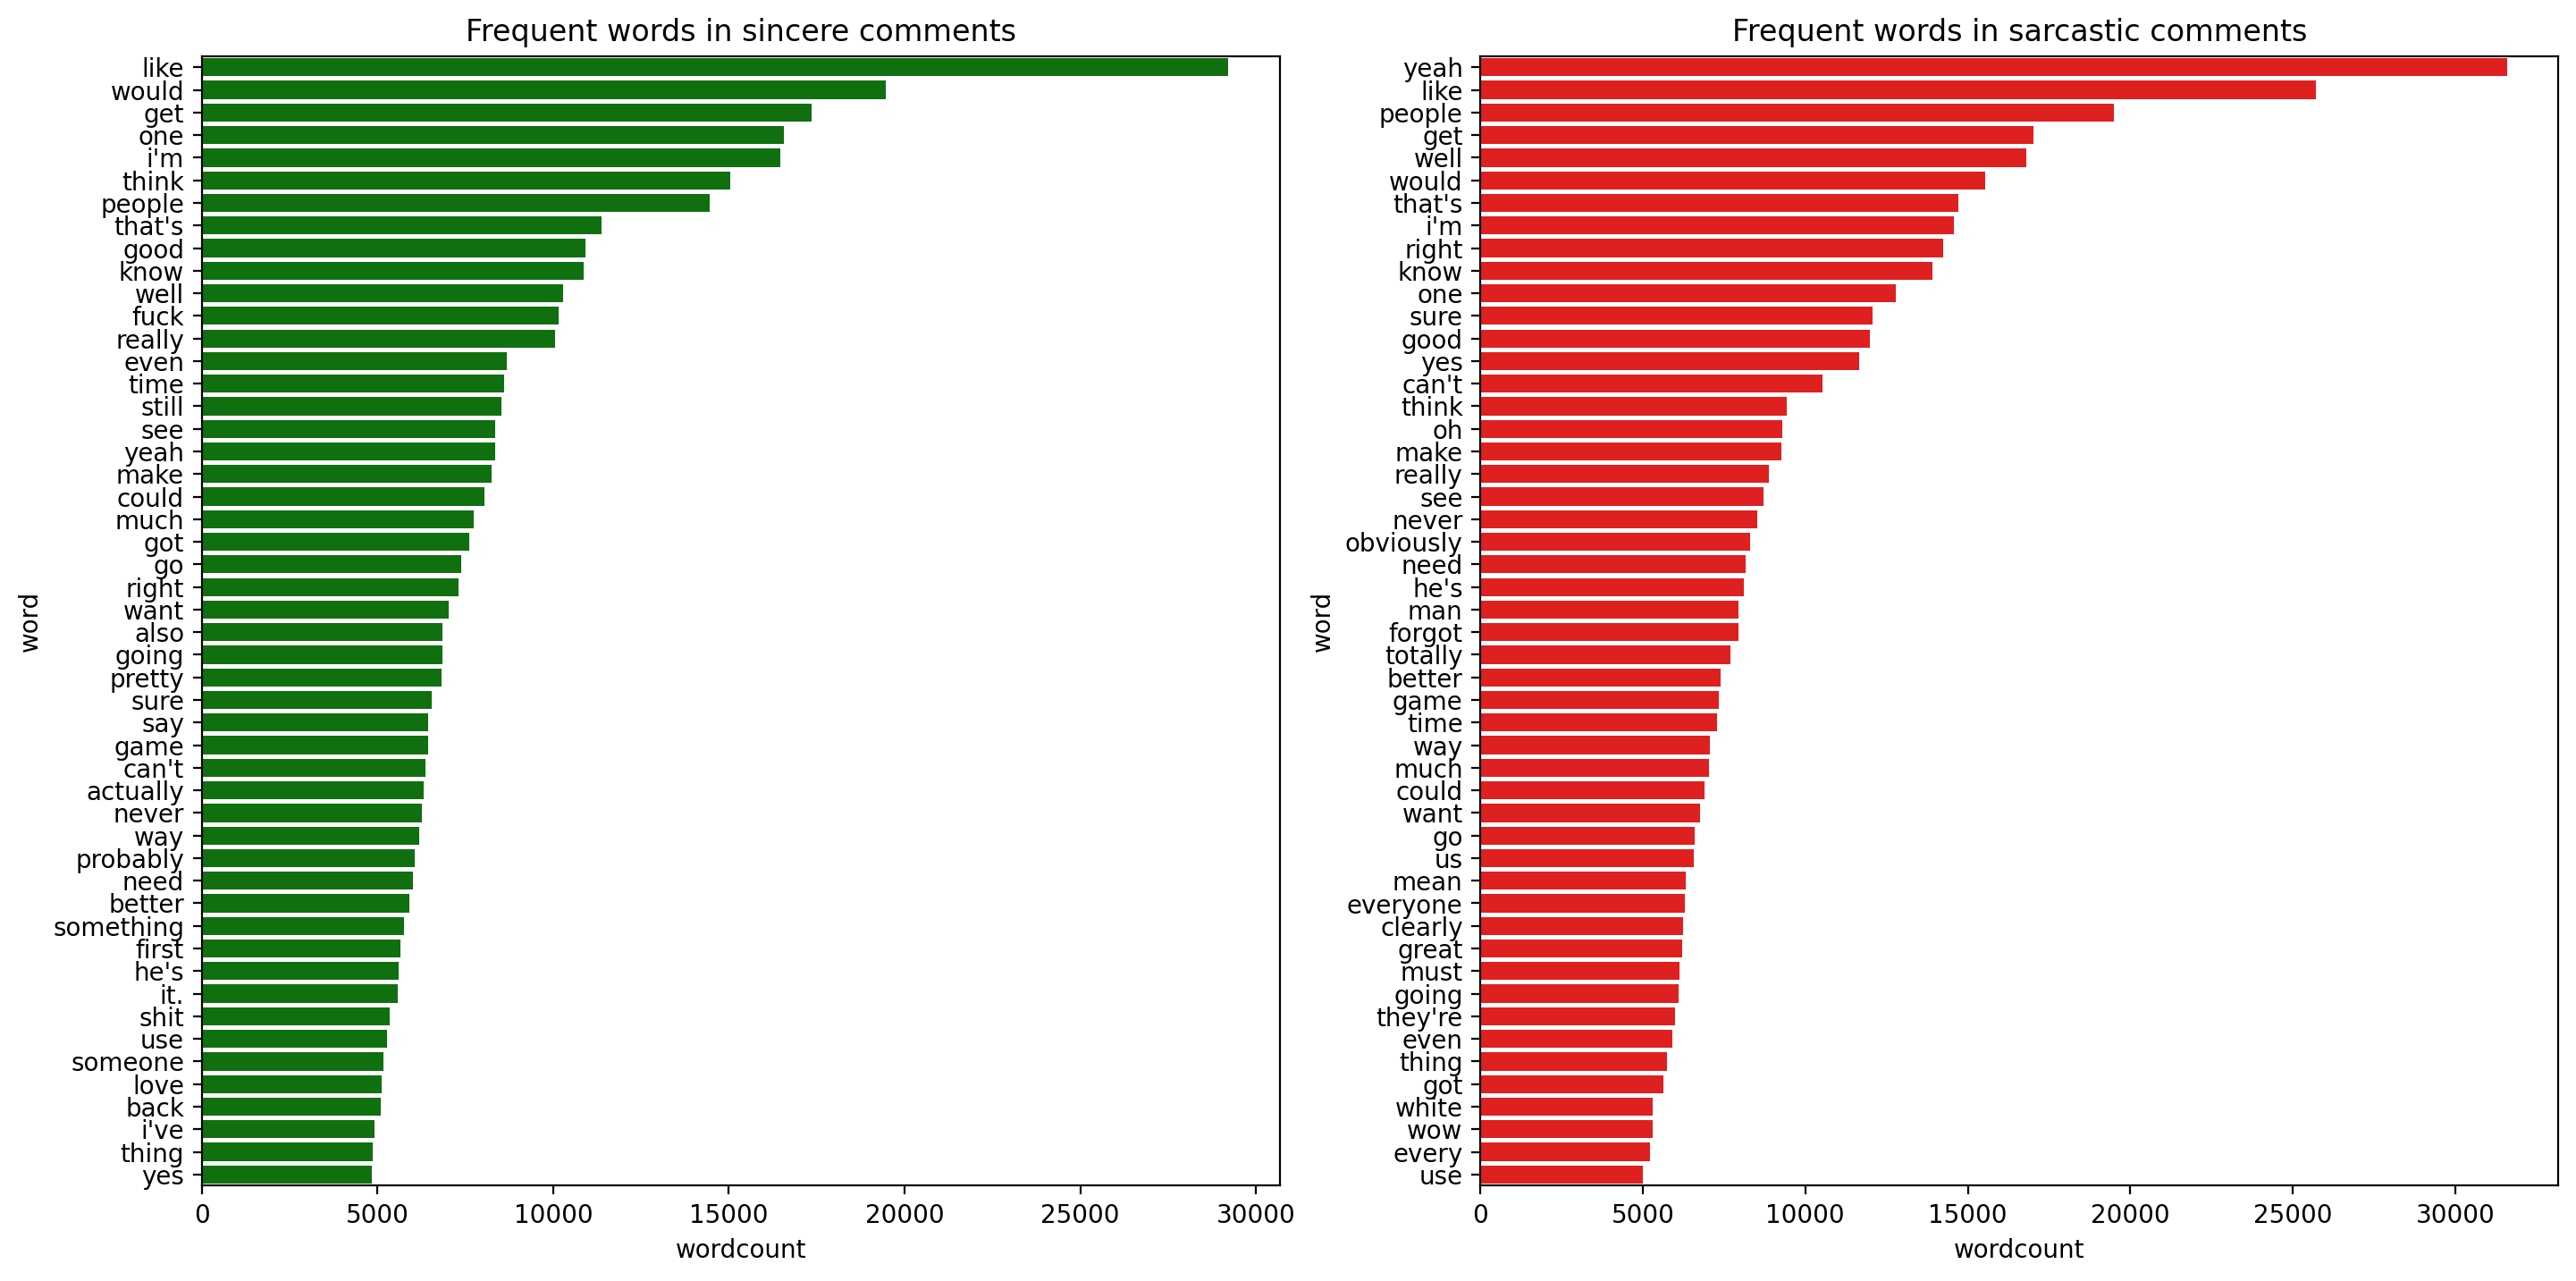

In [11]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
fig.tight_layout(pad=5.0)
sns.barplot(data=create_n_grams(df0.comment,1,50), y='word', x='wordcount', color='green', orient='h',ax=ax[0]).set_title('Frequent words in sincere comments')
sns.barplot(data=create_n_grams(df1.comment,1,50), y='word', x='wordcount', color='red', orient='h',ax=ax[1]).set_title('Frequent words in sarcastic comments')

Text(0.5, 1.0, 'Frequent bigrams in sarcastic comments')

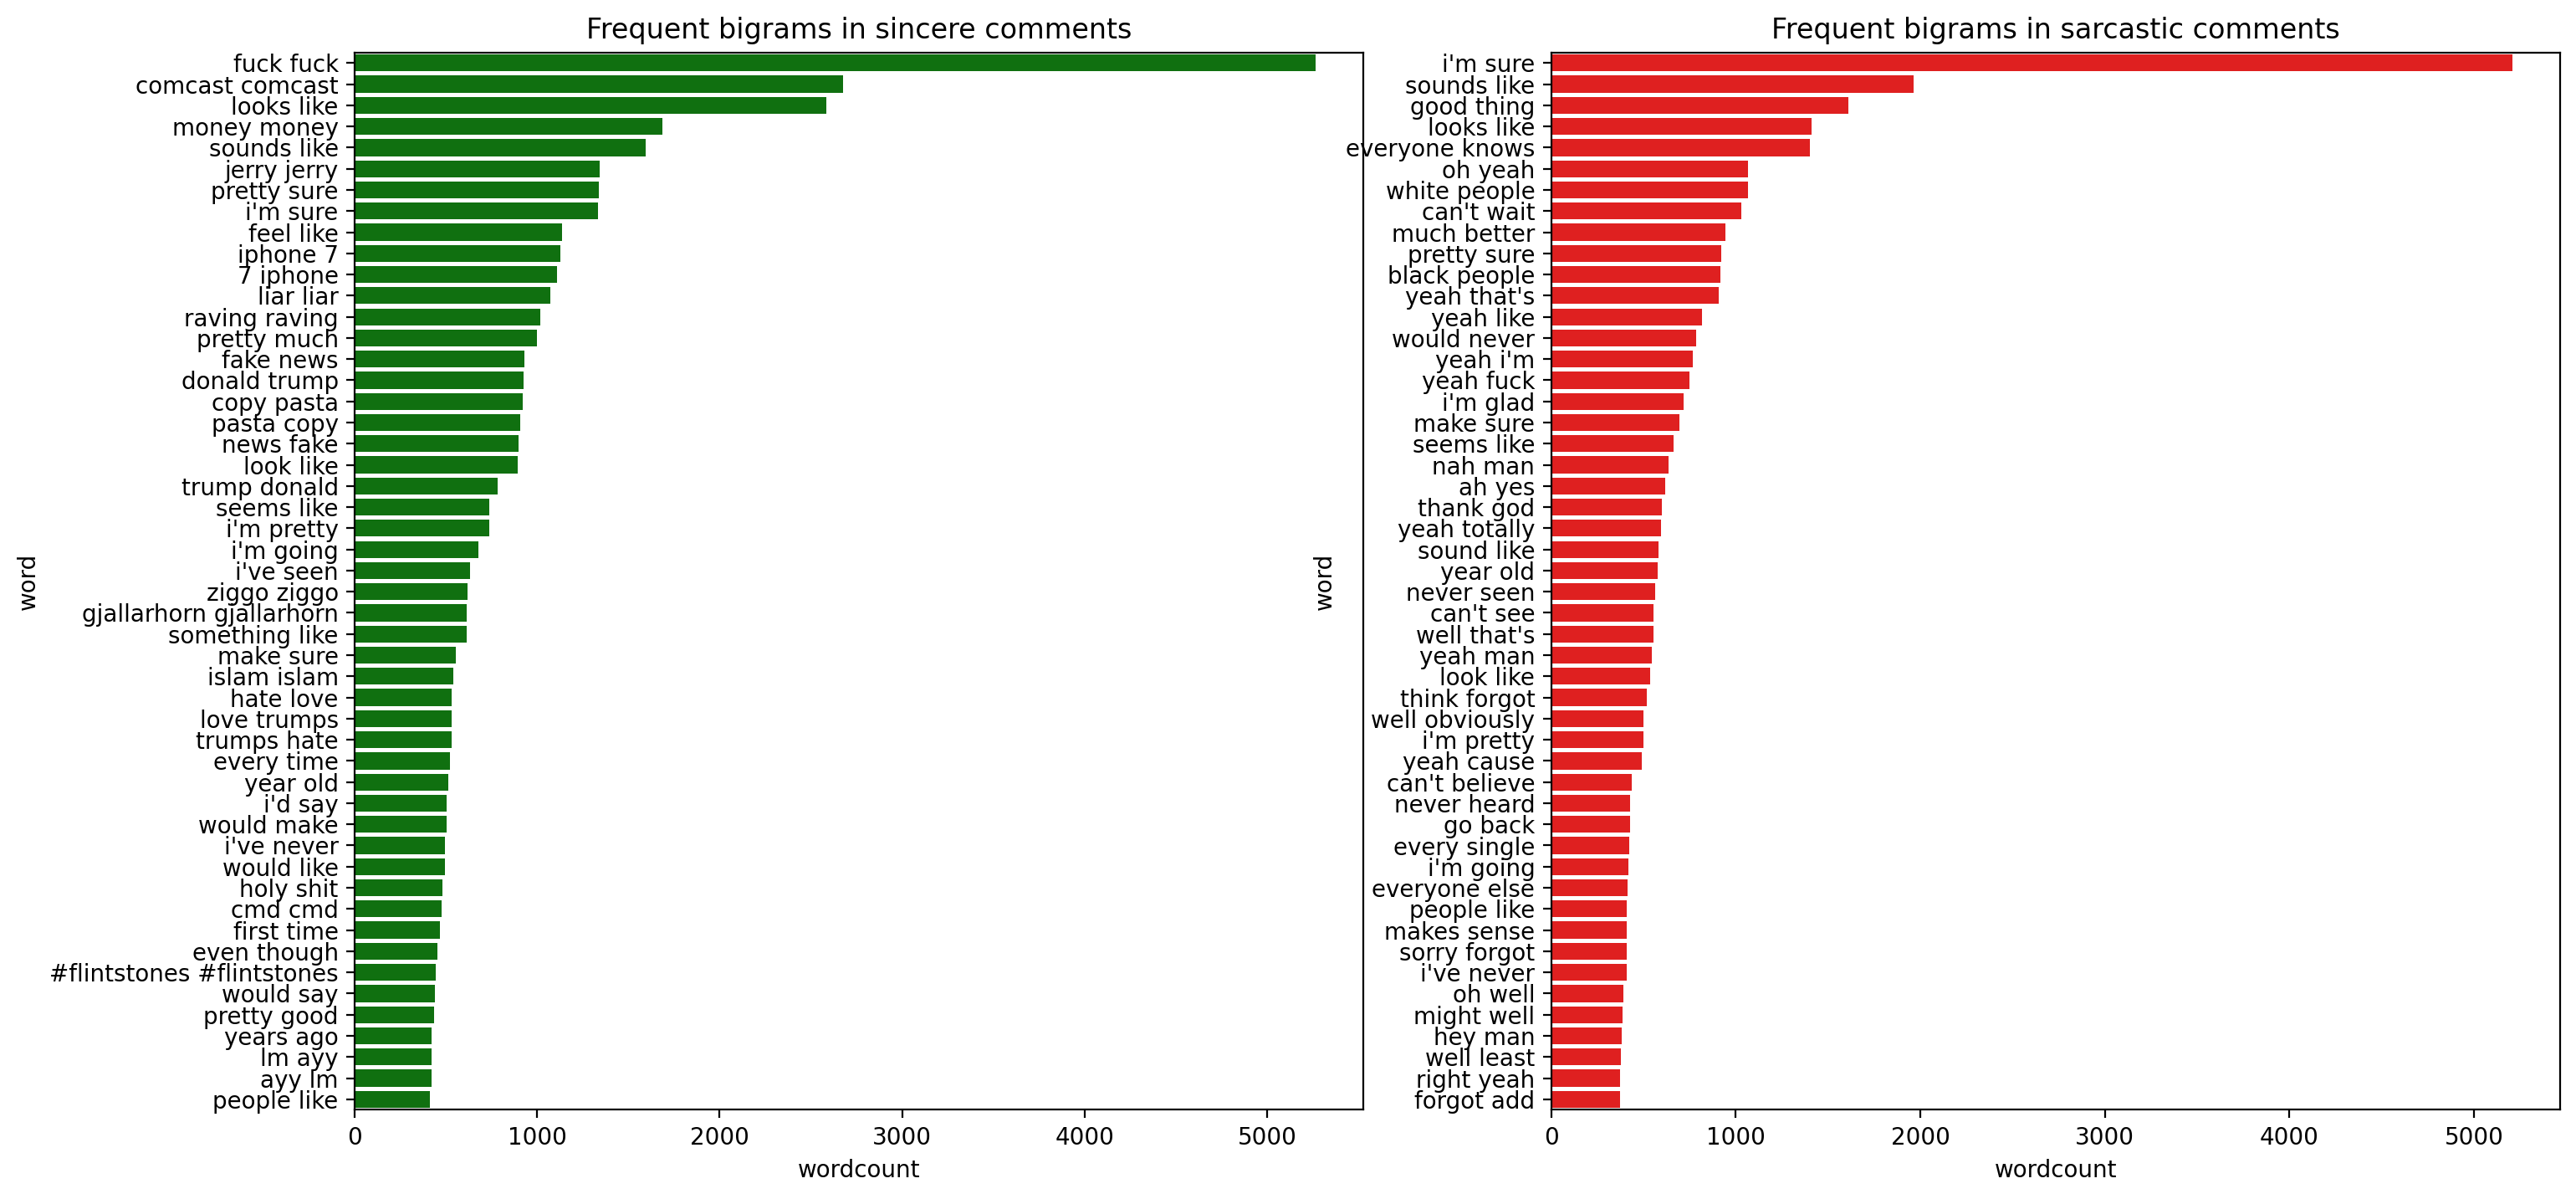

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
fig.tight_layout(pad=5.0)
sns.barplot(data=create_n_grams(df0.comment,2,50), y='word', x='wordcount', color='green', orient='h',ax=ax[0]).set_title('Frequent bigrams in sincere comments')
sns.barplot(data=create_n_grams(df1.comment,2,50), y='word', x='wordcount', color='red', orient='h',ax=ax[1]).set_title('Frequent bigrams in sarcastic comments')

Text(0.5, 1.0, 'Frequent trigrams in sarcastic comments')

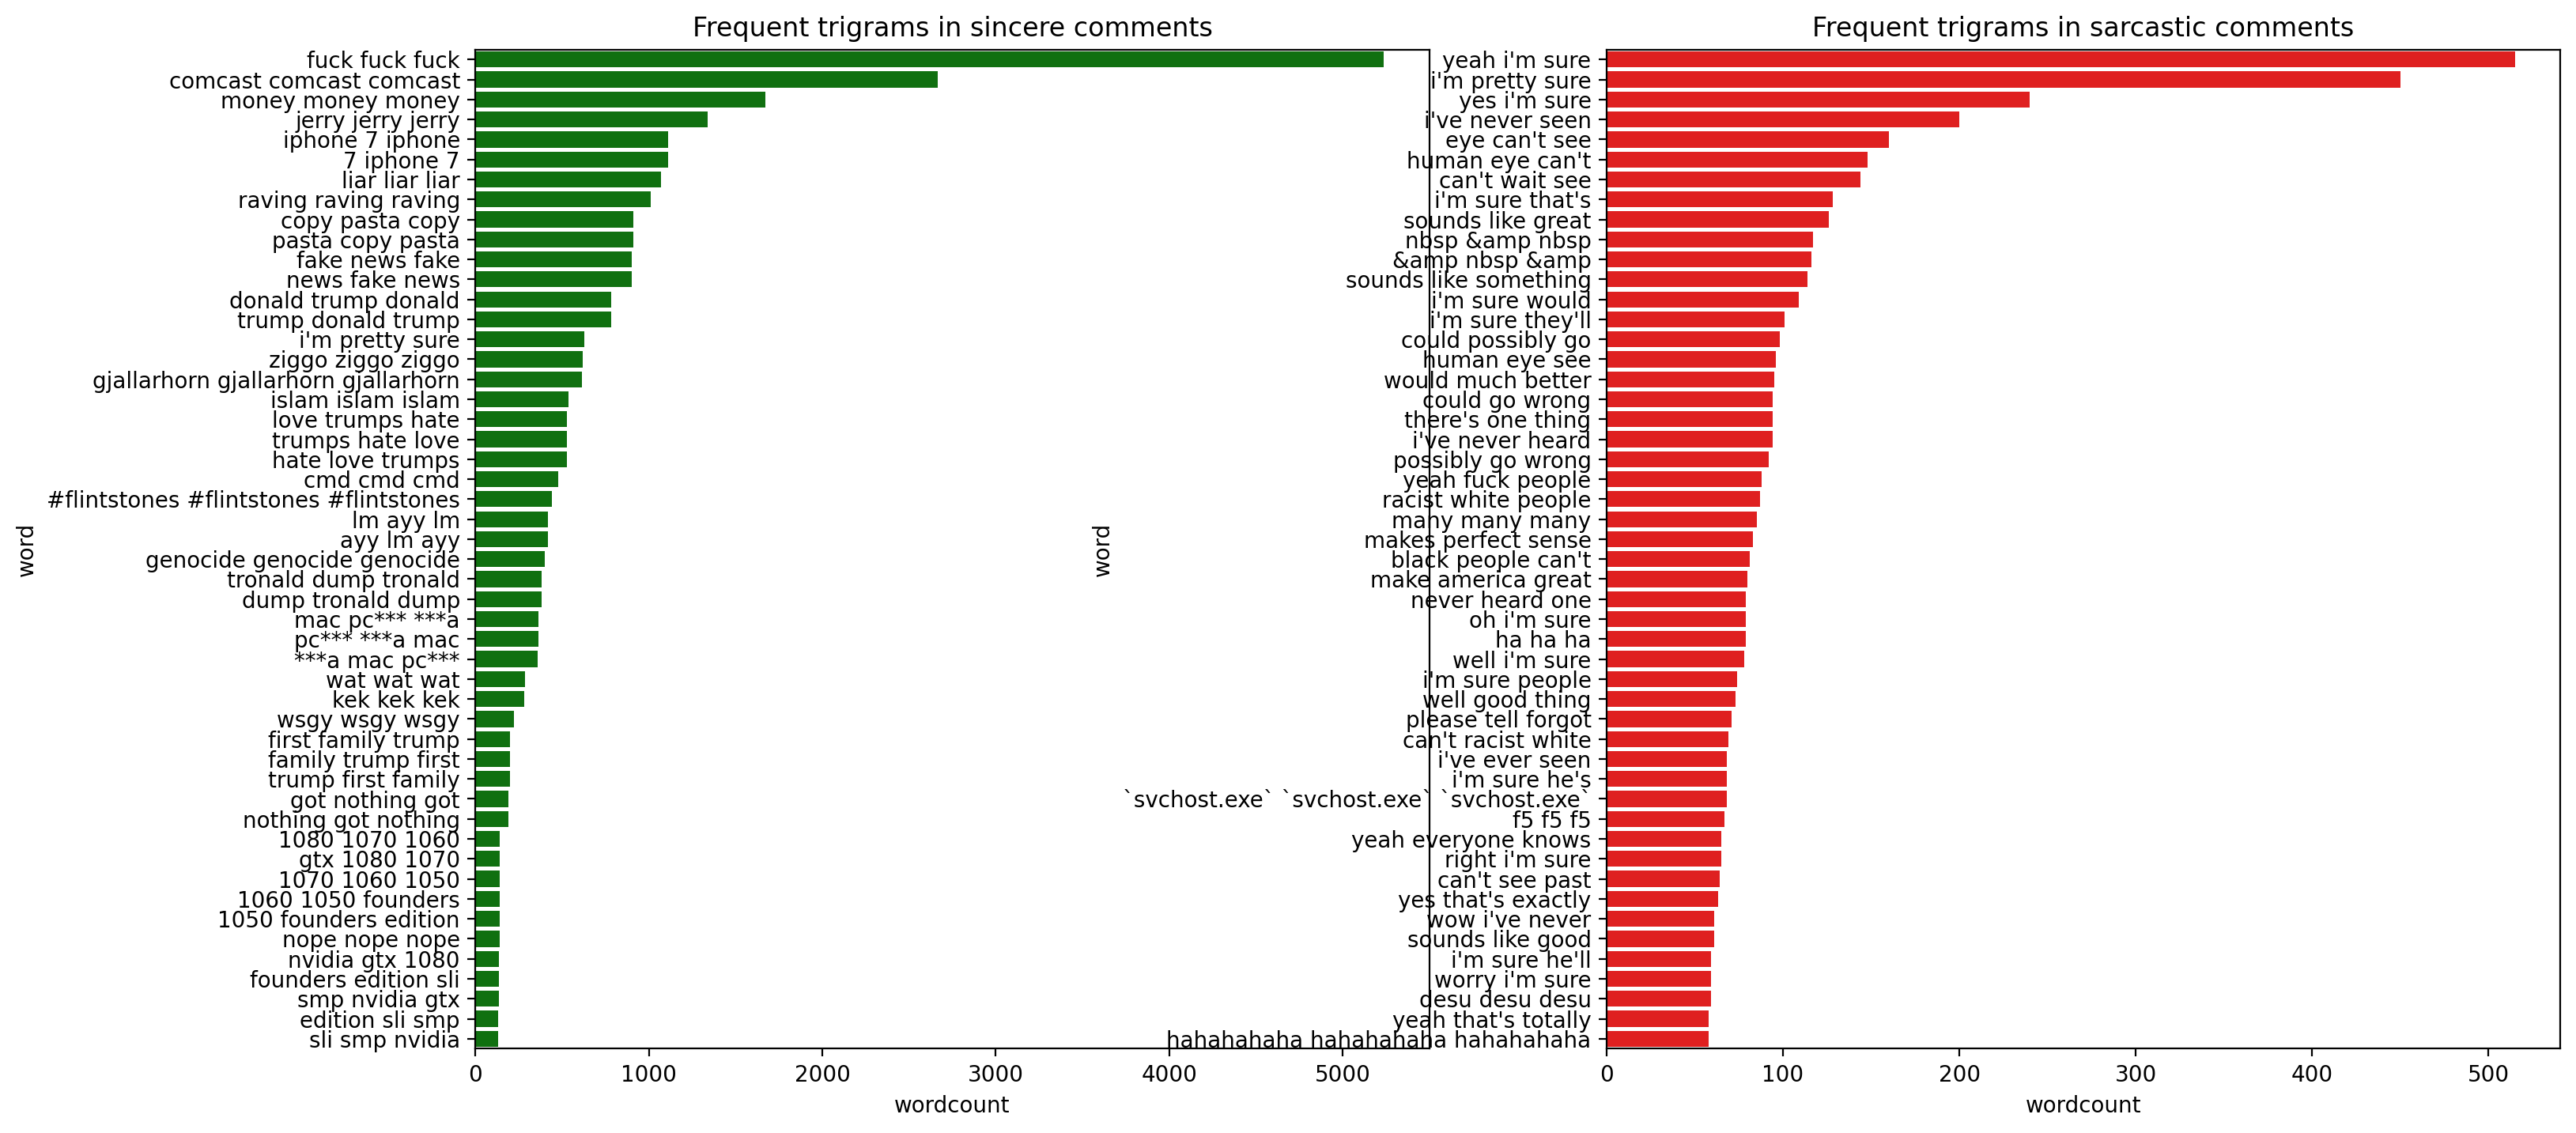

In [13]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
fig.tight_layout(pad=5.0)
sns.barplot(data=create_n_grams(df0.comment,3,50), y='word', x='wordcount', color='green', orient='h',ax=ax[0]).set_title('Frequent trigrams in sincere comments')
sns.barplot(data=create_n_grams(df1.comment,3,50), y='word', x='wordcount', color='red', orient='h',ax=ax[1]).set_title('Frequent trigrams in sarcastic comments')

Now let's try to see if length, the number of various punctuation marks, stop words etc can be useful features to distinguish sarcastic comments from sincere ones.

In [20]:
df['length_words'] = df['comment'].apply(lambda x: len(str(x).split()))
df['unique_words'] = df['comment'].apply(lambda x: len(set(str(x).split())))
df['length_chars'] = df['comment'].apply(lambda x: len(str(x)))
df['stopwords'] = df['comment'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
df['punct'] = df['comment'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
df['num_of_ex'] = df['comment'].apply(lambda x: len([c for c in str(x) if c == '!']))
df['num_of_q'] = df['comment'].apply(lambda x: len([c for c in str(x) if c == '?']))
df['num_of_dots'] = df['comment'].apply(lambda x: len([c for c in str(x) if c == '.']))
df['num_of_commas'] = df['comment'].apply(lambda x: len([c for c in str(x) if c == ',']))
df['emoji'] = df['comment'].apply(lambda x: x.count(': )'))

Let's first examine the number of :) emojis. This feature has only 5 values, so it doesn't really make sense to plot it.

In [15]:
df.groupby(by=['label', 'emoji']).comment.count()

label  emoji
0      0        502155
       1          3219
       2            26
       3             5
1      0        504857
       1           502
       2             6
       3             2
       6             1
Name: comment, dtype: int64

There is only 1 comment with 6 :), so we can disregard it. Overall, among comments with at least one :) sincere comments are 5 times for frequent. So let's make a binary feature out of it.

In [21]:
df['emoji'] = df['emoji'].apply(lambda x: 1 if x > 0 else 0)

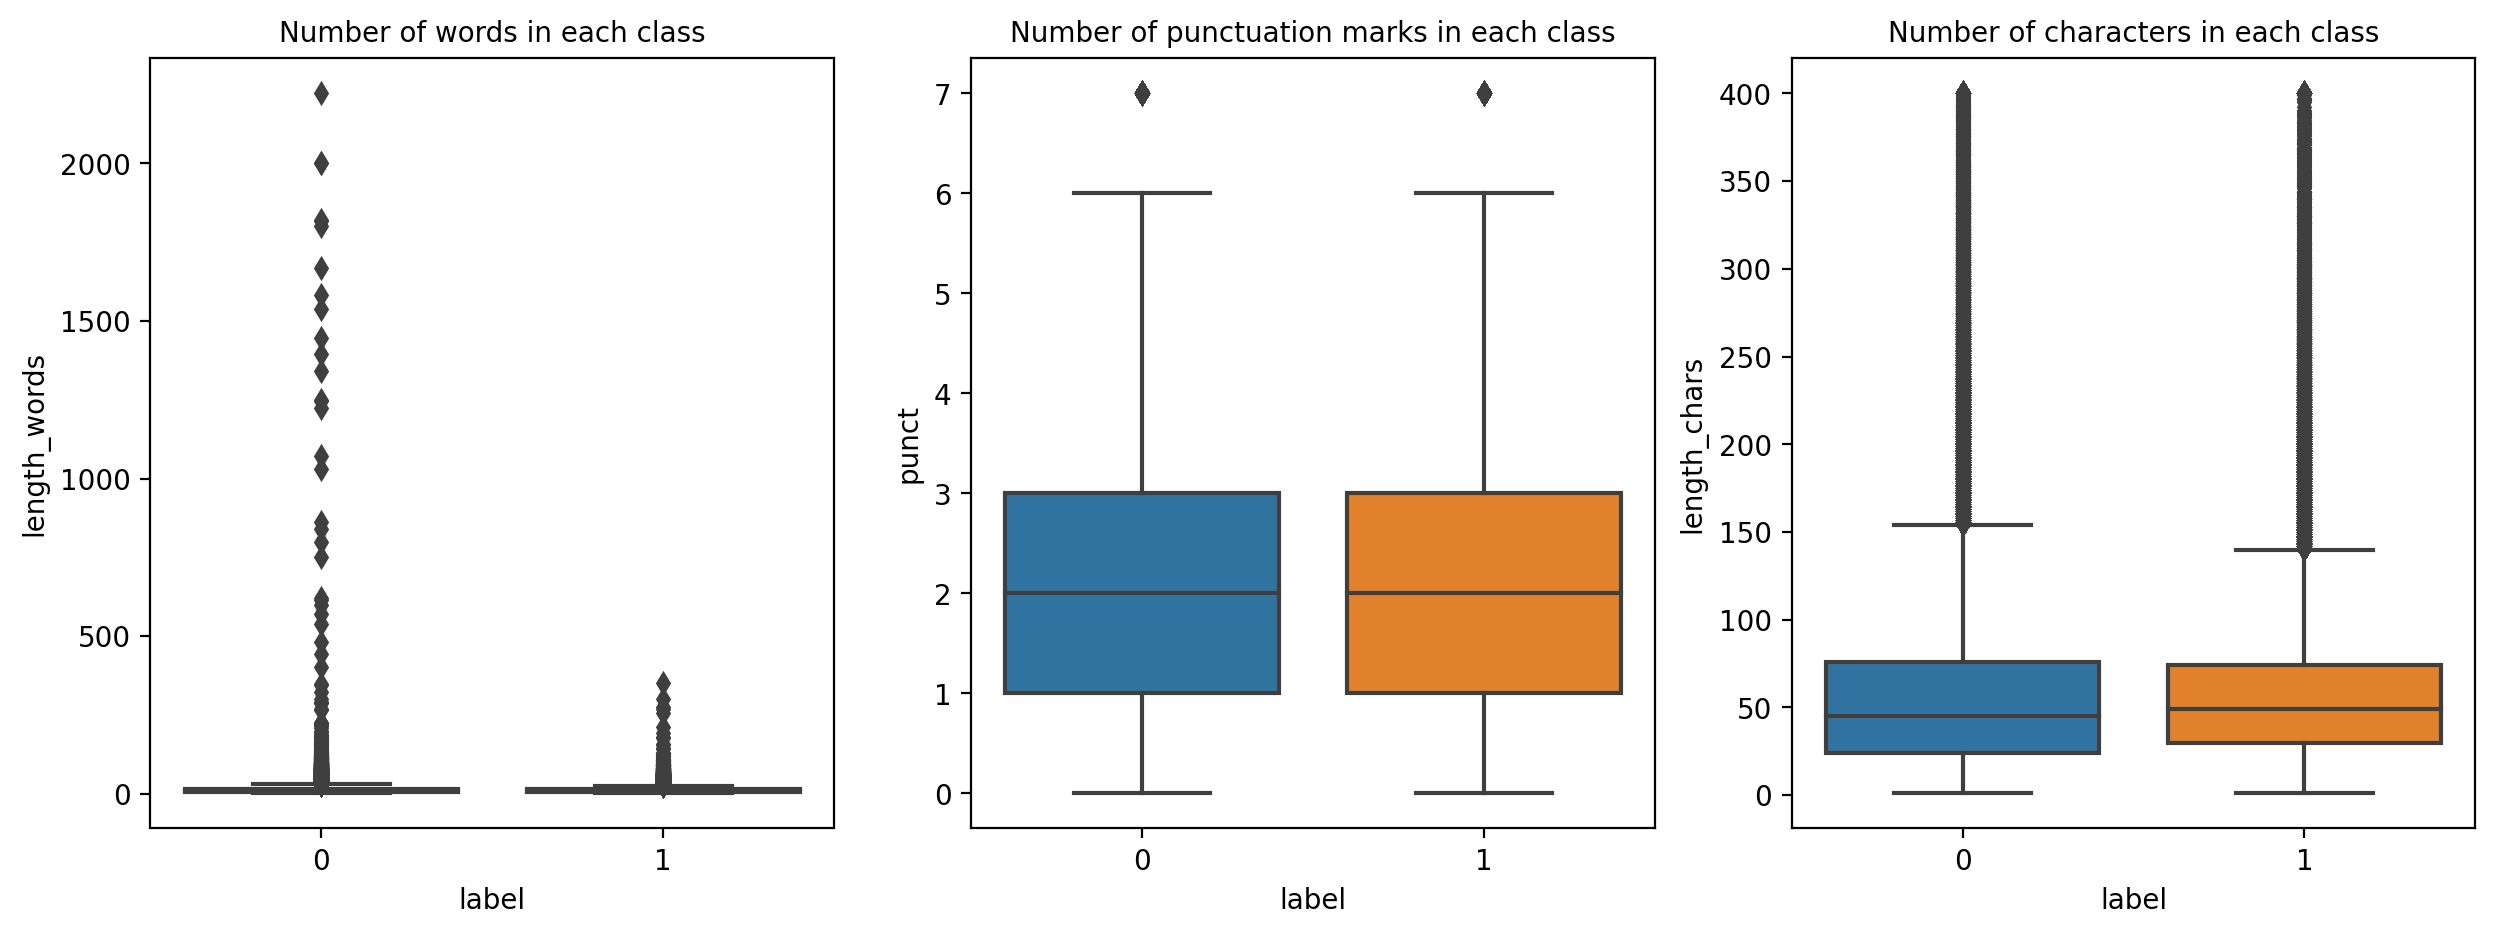

In [17]:
#X['length_words'].loc[X['length_words']>50] = 50
df['punct'].loc[df['punct']>7] = 7
df['length_chars'].loc[df['length_chars']>400] = 400

f, axes = plt.subplots(1, 3, figsize=(15,5))

sns.boxplot(x='label', y='length_words', data=df, ax=axes[0])
axes[0].set_title('Number of words in each class', fontsize=10)

sns.boxplot(x='label', y='punct', data=df, ax=axes[1])
axes[1].set_title('Number of punctuation marks in each class', fontsize=10)

sns.boxplot(x='label', y='length_chars', data=df, ax=axes[2])
axes[2].set_title('Number of characters in each class', fontsize=10)

plt.show()

We can see that the number of punctuation marks and the number of characters are not very helpful, but sarcastic comments tend to contain less words, so we might keep it as a feature.

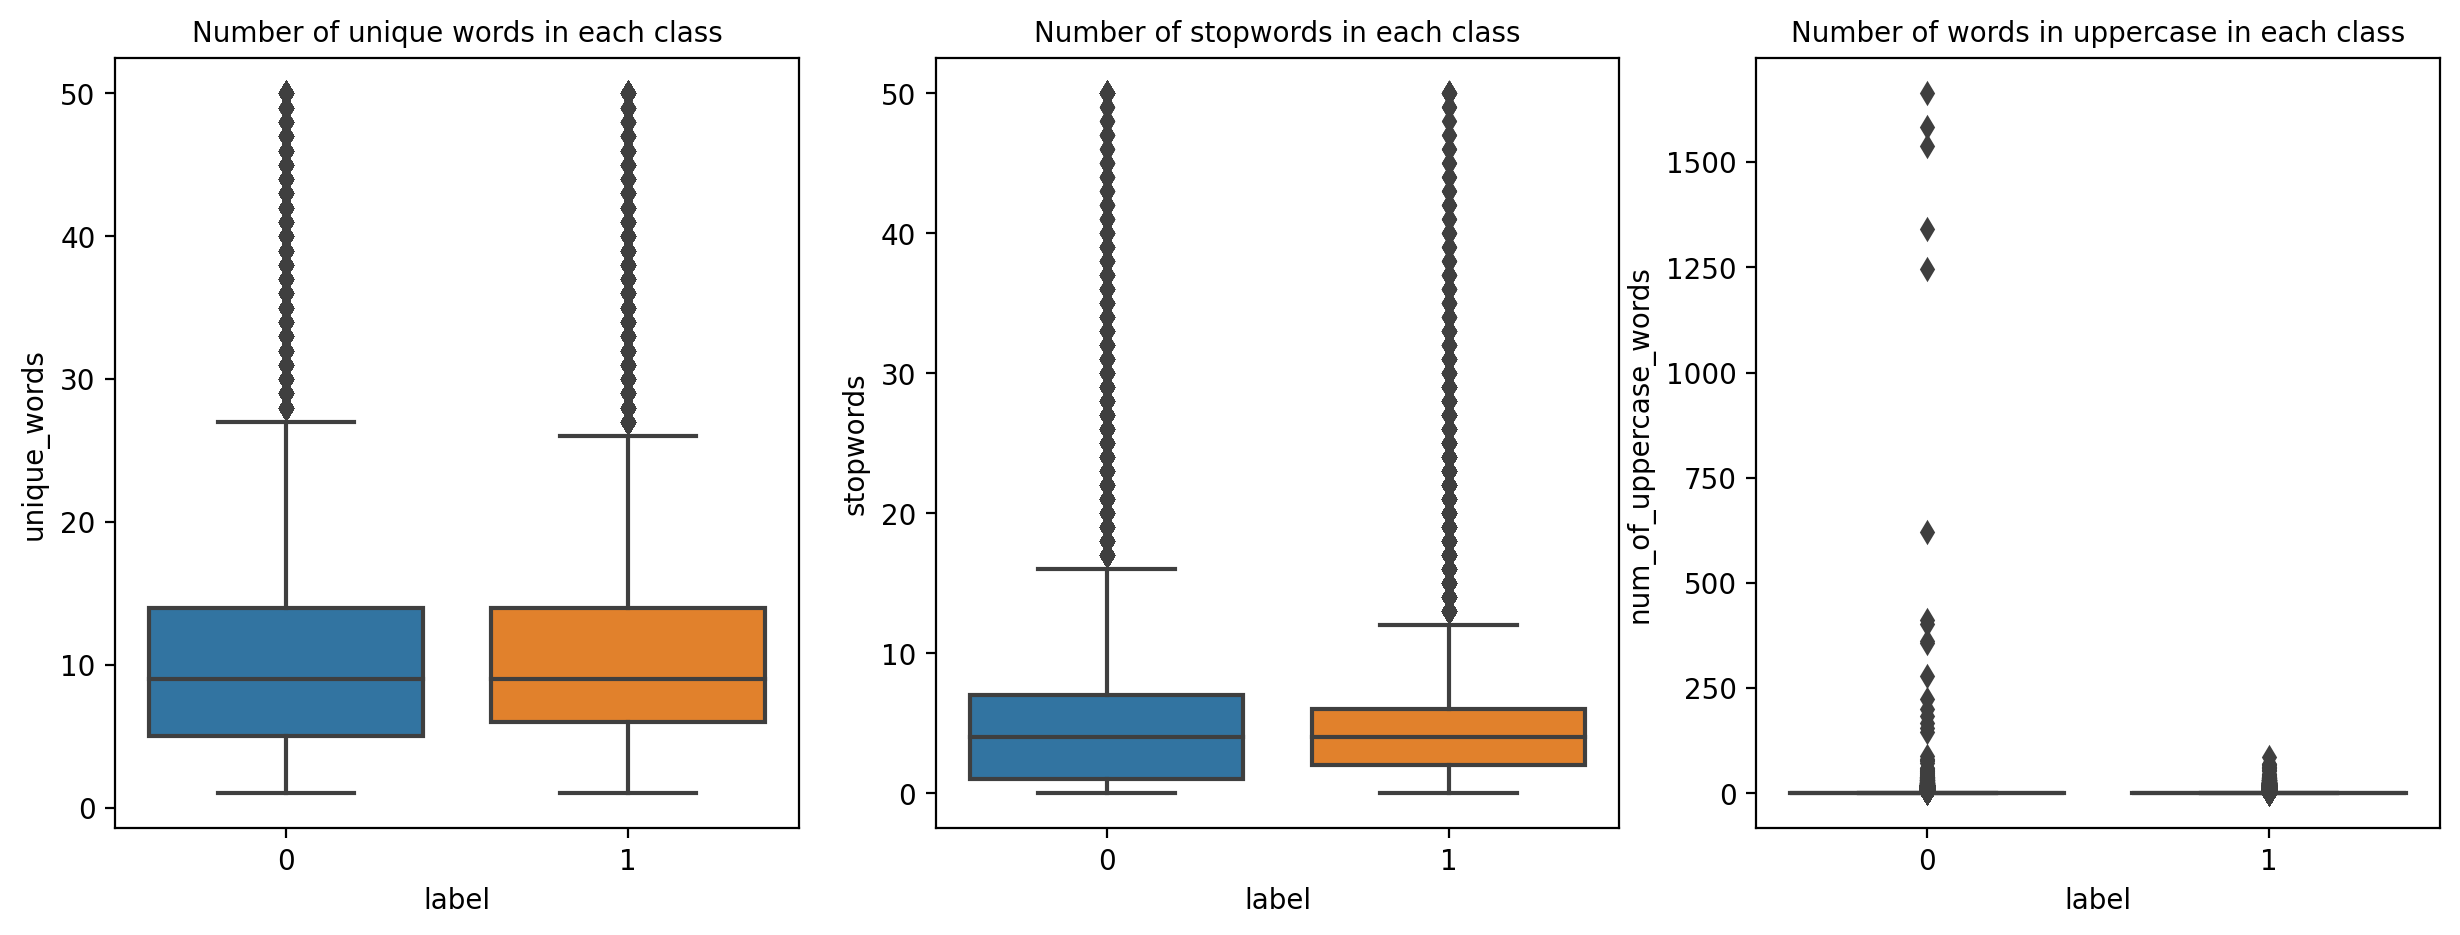

In [18]:
df['unique_words'].loc[df['unique_words']>50] = 50
df['stopwords'].loc[df['stopwords']>50] = 50

f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.boxplot(x='label', y='unique_words', data=df, ax=axes[0])
axes[0].set_title('Number of unique words in each class', fontsize=10)

sns.boxplot(x='label', y='stopwords', data=df, ax=axes[1])
axes[1].set_title('Number of stopwords in each class', fontsize=10)

sns.boxplot(x='label', y='num_of_uppercase_words', data=df, ax=axes[2])
axes[2].set_title('Number of words in uppercase in each class', fontsize=10)

plt.show()

The number of words in uppercase is interesting. In fact, most comments in both classes have no uppercase words, but sincere comments still tend to have more uppercase words than sarcastic ones. For sincere comments the distribution has a much longer tail:

In [19]:
df[df['label']==1].num_of_uppercase_words.describe()

count    505368.000000
mean          0.388222
std           1.358376
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          86.000000
Name: num_of_uppercase_words, dtype: float64

In [20]:
df[df['label']==0].num_of_uppercase_words.describe()

count    505405.000000
mean          0.451547
std           5.058828
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        1663.000000
Name: num_of_uppercase_words, dtype: float64

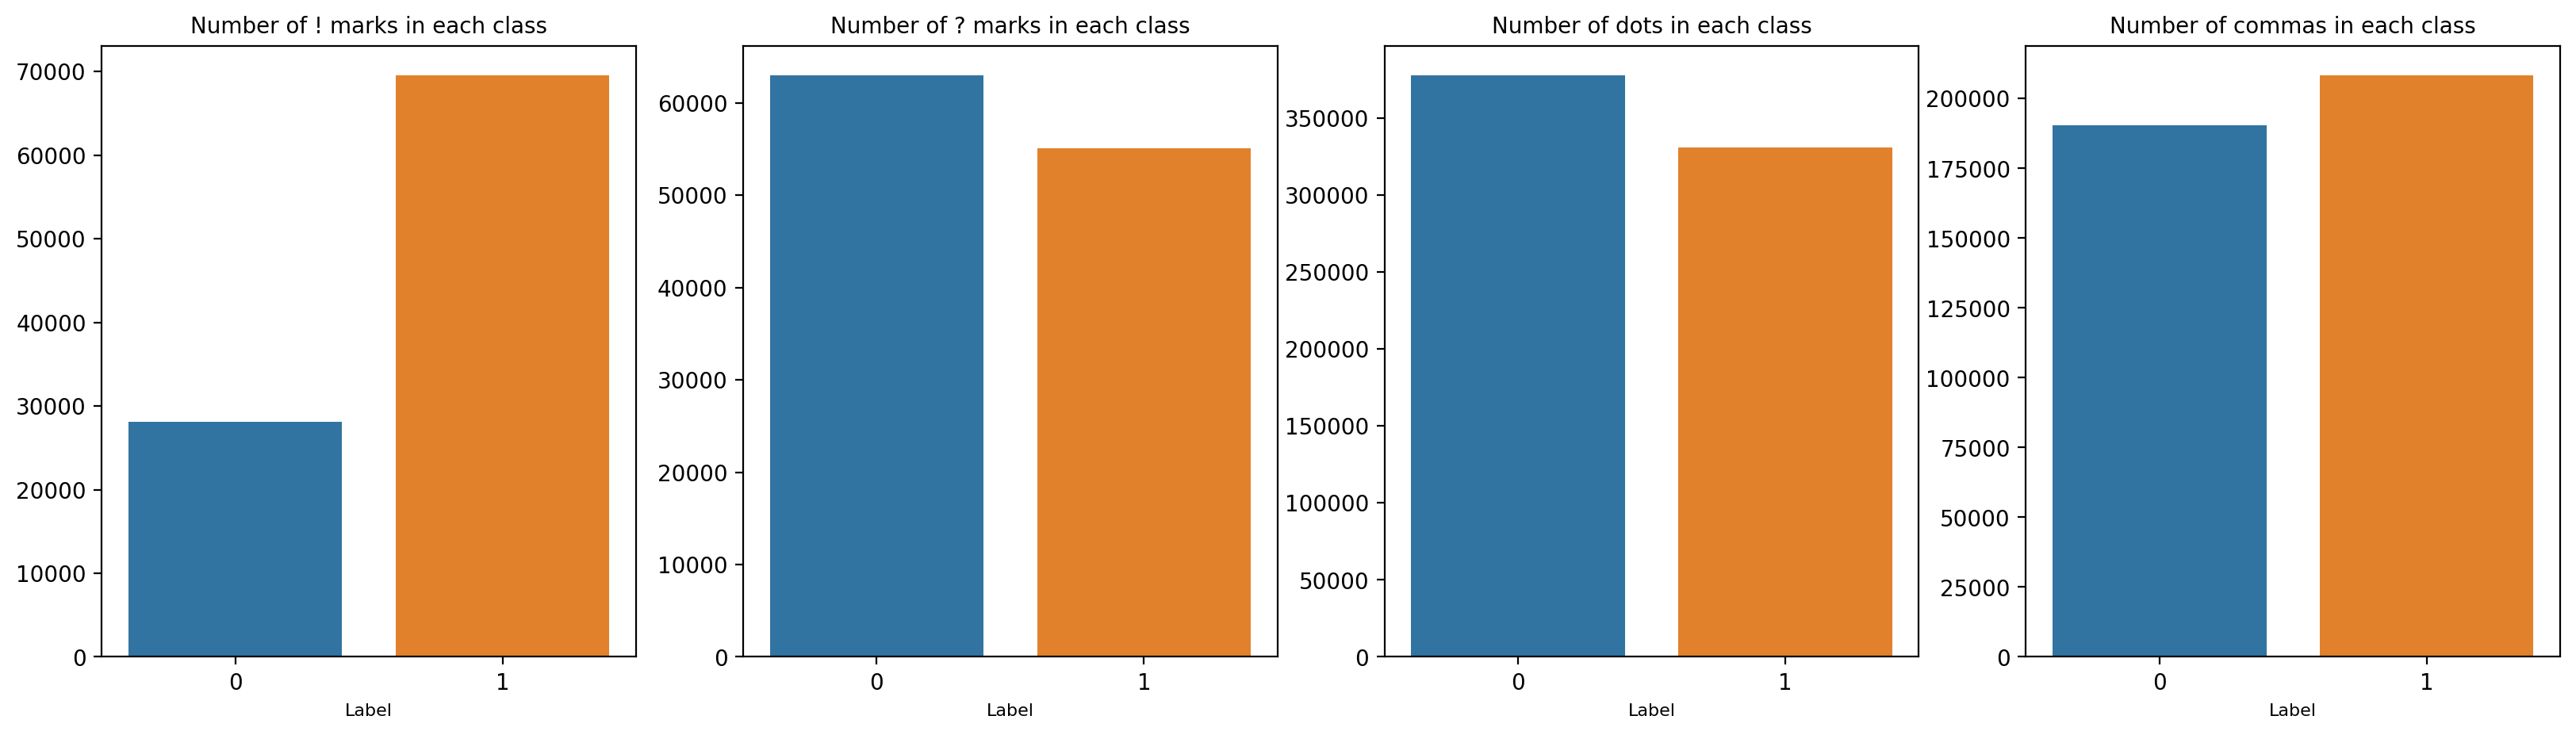

In [21]:
df['num_of_dots'].loc[df['num_of_dots']>50] = 50
df['num_of_commas'].loc[df['num_of_commas']>50] = 50

f, axes = plt.subplots(1, 4, figsize=(20,5))
sns.barplot(x='label', y='num_of_ex', data=df, ax=axes[0],estimator=sum, ci=None)
axes[0].set_xlabel('Label', fontsize=8)
axes[0].set_ylabel('')
axes[0].set_title('Number of ! marks in each class', fontsize=10)

sns.barplot(x='label', y='num_of_q', data=df, ax=axes[1],estimator=sum, ci=None)
axes[1].set_xlabel('Label', fontsize=8)
axes[1].set_ylabel('')
axes[1].set_title('Number of ? marks in each class', fontsize=10)

sns.barplot(x='label', y='num_of_dots', data=df, ax=axes[2],estimator=sum, ci=None)
axes[2].set_xlabel('Label', fontsize=8)
axes[2].set_ylabel('')
axes[2].set_title('Number of dots in each class', fontsize=10)

sns.barplot(x='label', y='num_of_commas', data=df, ax=axes[3],estimator=sum, ci=None)
axes[3].set_xlabel('Label', fontsize=8)
axes[3].set_ylabel('')
axes[3].set_title('Number of commas in each class', fontsize=10)

plt.show()

The number of exclamation marks seems useful, so we are going to include it.

Finally, let's find out which subreddits are the most sarcastic. For this we will restrict outselves to subreddits which have more than 1000 comments.

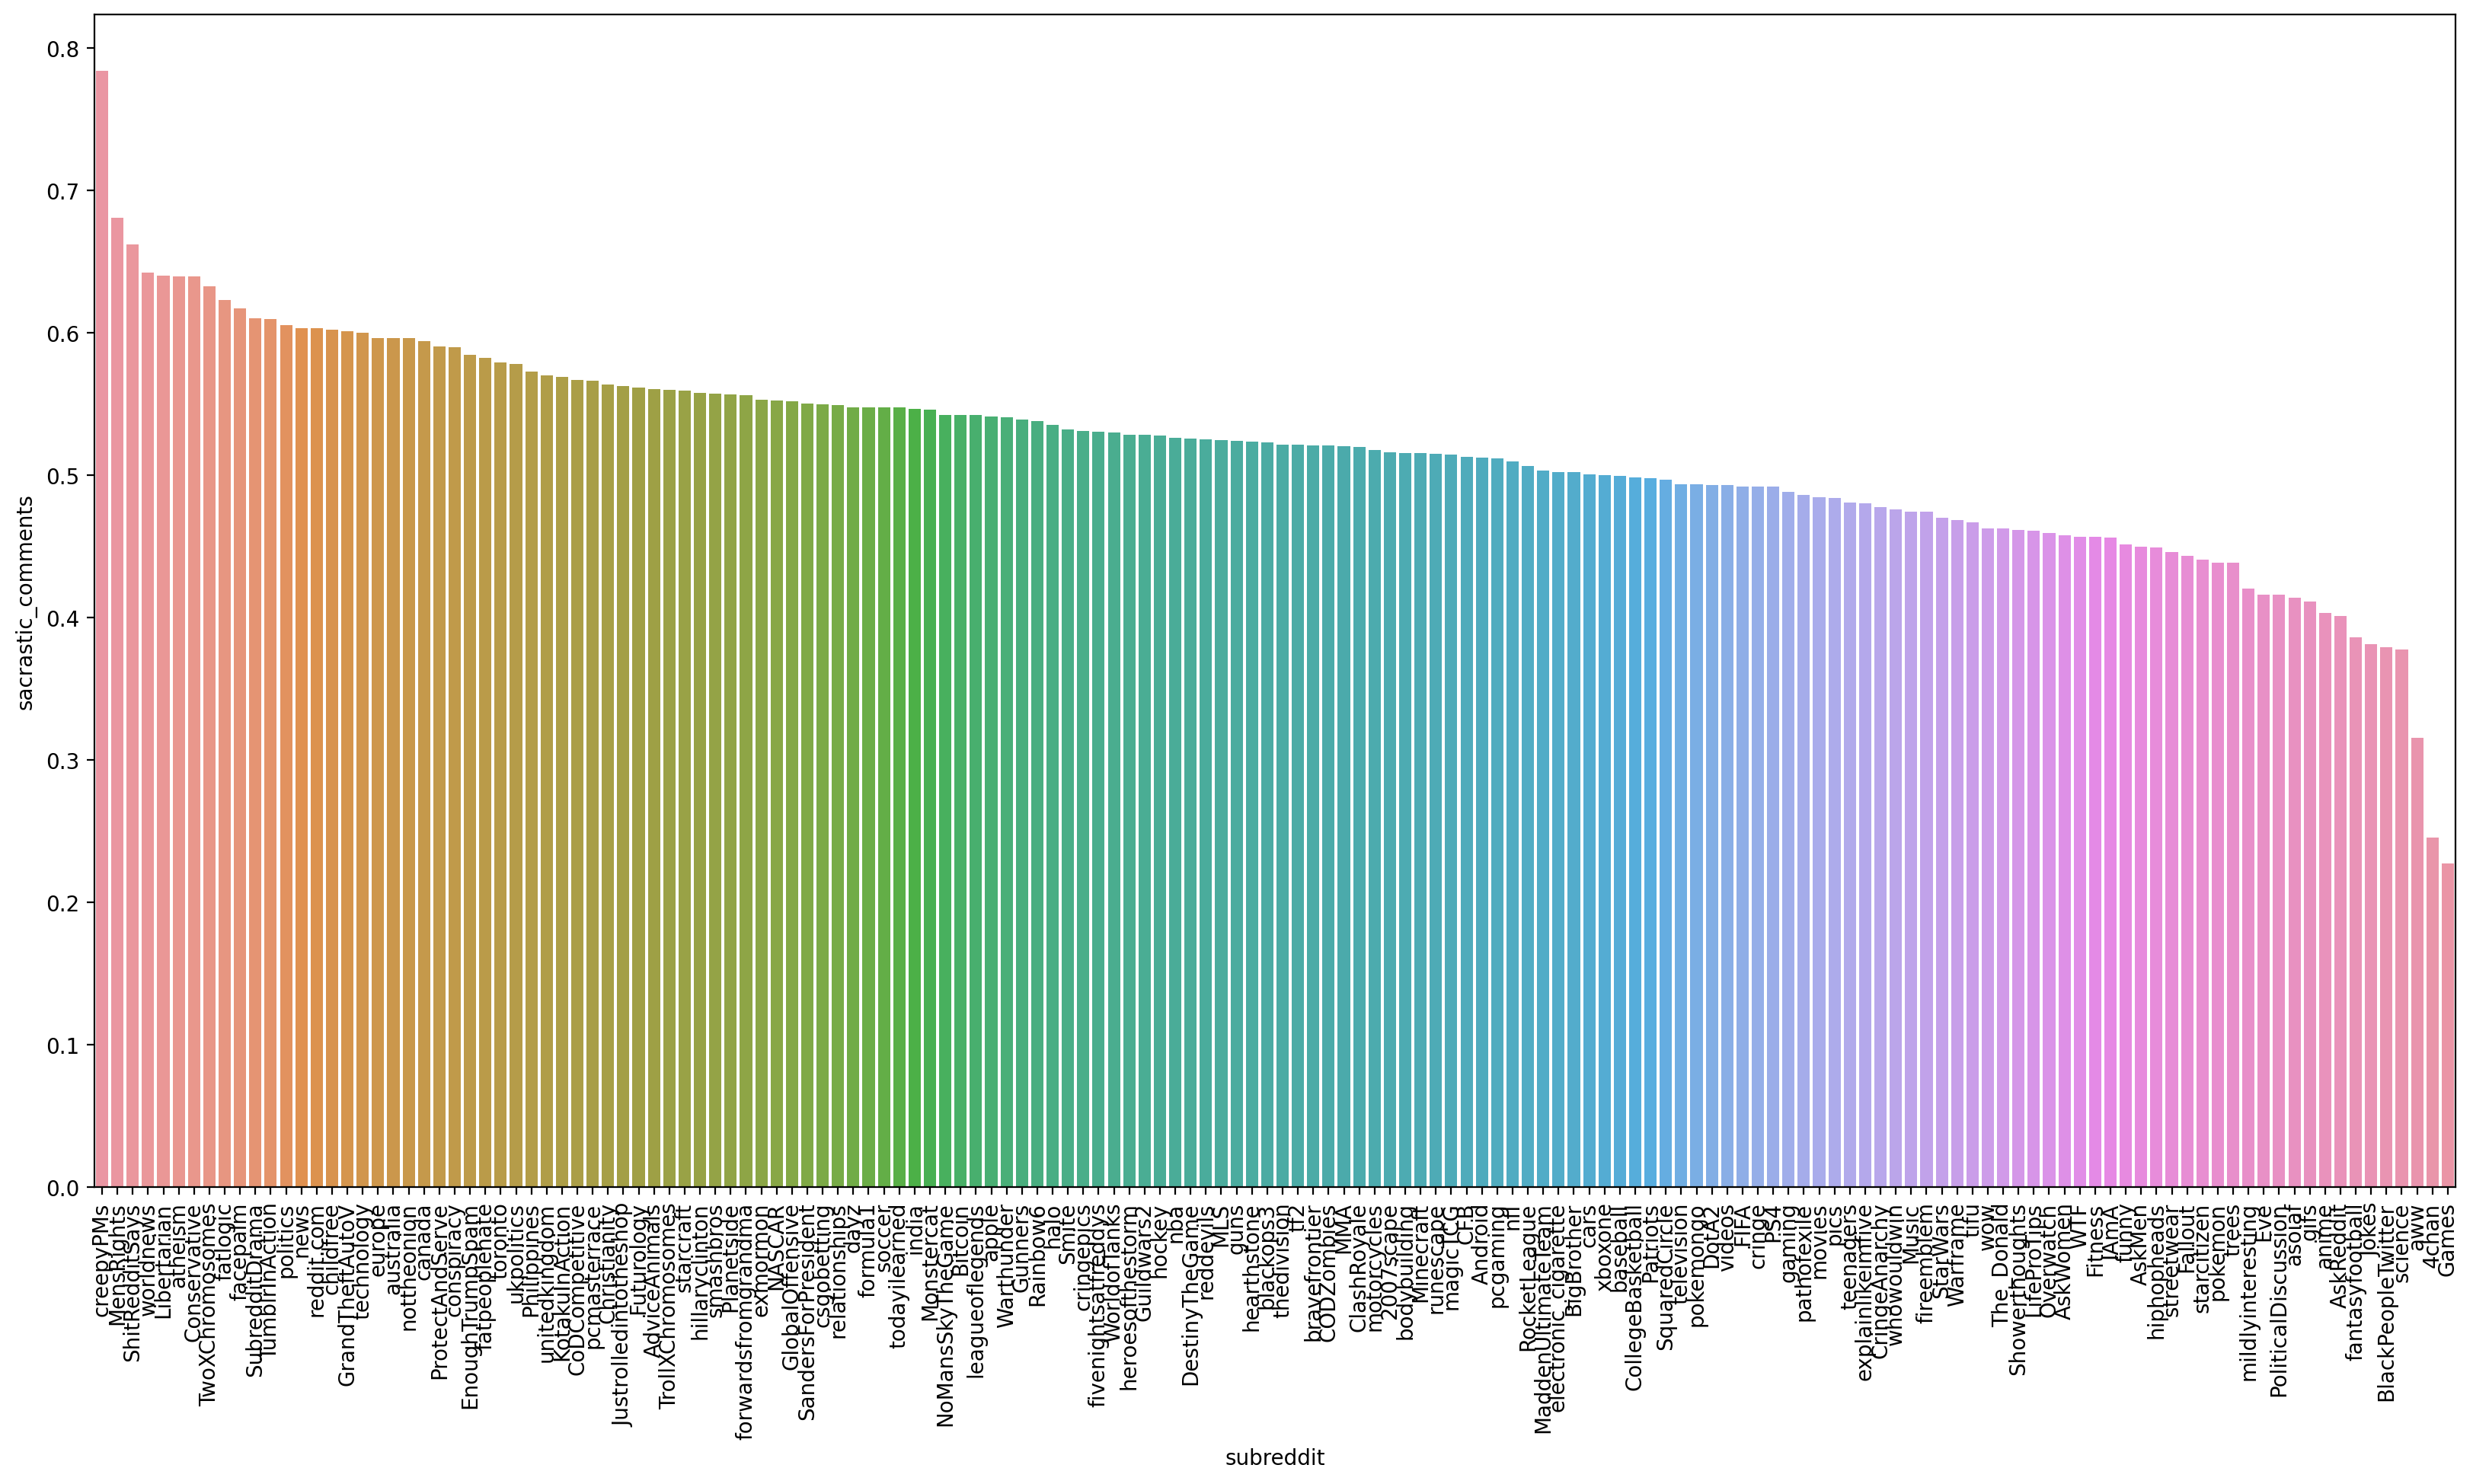

In [22]:
sub_df = df.groupby('subreddit')['label'].agg([np.size, np.mean]).sort_values(by='mean',ascending=False)
sub_df.columns = ['size','sacrastic_comments']
sub_df_big = sub_df[sub_df['size'] > 1000]
plt.figure(figsize=(20,10))
sns.barplot(data=sub_df_big, x=sub_df_big.index, y='sacrastic_comments')
plt.xticks(rotation=90)
plt.show()

In [23]:
print('There are ',len(sub_df[sub_df['sacrastic_comments'] == 0]),' subreddits with only sincere comments.')
print('There are ', len(sub_df[sub_df['sacrastic_comments'] == 1]),' subreddits with only sarcastic comments.')

There are  5883  subreddits with only sincere comments.

There are  2040  subreddits with only sarcastic comments.


We can see that perhaps this can be a useful feature for future training. 

In [22]:
df.drop(columns=['num_of_commas','num_of_dots','num_of_q','stopwords','unique_words','punct', 'score','length_chars'], inplace=True)

Let's look at what we have after we had removed and added some columns: 

In [25]:
df.head()

,label,comment,subreddit,ups,downs,num_of_uppercase_words,length_words,num_of_ex,emoji
0,0,nc and nh.,politics,-1,-1,2,3,0,0
1,0,you do know west teams play against west teams...,nba,-1,-1,0,15,0,0
2,0,"they were underdogs earlier today , but since ...",nfl,3,0,0,21,0,0
3,0,"this meme isn't funny none of the "" new york n...",BlackPeopleTwitter,-1,-1,0,14,0,0
4,0,i could use one of those tools.,MaddenUltimateTeam,-1,-1,1,7,0,0


Finally, let's split the data into train and validation datasets.

In [23]:
SEED = 1

In [24]:
df_train, df_valid = train_test_split(df, random_state=SEED)

In [25]:
y_train = df_train['label']
X_train = df_train.drop(columns=['label'])

y_valid = df_valid['label']
X_valid = df_valid.drop(columns=['label'])

## Logistic regression

First we will train a simple logistic regression using tf–idf. We are going to apply one-hot encoding to the subreddit feature and scale all numerical features.

In [26]:
tfidf_vec = TfidfVectorizer(min_df=3,  max_features=None,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
enc = OneHotEncoder(handle_unknown='ignore')
X_train_sr = enc.fit_transform(X_train[['subreddit','emoji']])
X_val_sr = enc.transform(X_valid[['subreddit','emoji']])

train_comments = tfidf_vec.fit_transform(X_train['comment'])
valid_comments = tfidf_vec.transform(X_valid['comment'])


In [27]:
numeric_features = ['ups','downs','num_of_uppercase_words','length_words','num_of_ex']
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_features])
X_val_num = scaler.transform(X_valid[numeric_features])

In [29]:
X_t = hstack([train_comments, X_train_sr, X_train_num])
X_v = hstack([valid_comments, X_val_sr, X_val_num])

In [32]:
%%time
logit = LogisticRegression()
logit.fit(X_t, y_train)

CPU times: user 23.3 s, sys: 16.2 s, total: 39.5 s

Wall time: 28 s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:



lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




LogisticRegression()

In [33]:
print(f"The accuracy on the training dataset is: {logit.score(X_t,y_train)}")
print(f"The accuracy on the test dataset is:  {logit.score(X_v,y_valid)}")

The accuracy on the training dataset is: 0.700126240141199

The accuracy on the test dataset is:  0.6865893135571086


With default hyperparameters our logistic regression has failed to converge, but we still got a reasonable score. Now let's tune the hyperparameters. Because our dataset is quite large, we will only use a portion of it to find optimal hyperparameters.

In [30]:
_, X_small, _, y_small = train_test_split(X_t, y_train, random_state=2, test_size=0.1)
_, X_small_v, _, y_small_v = train_test_split(X_v, y_valid, random_state=2, test_size=0.1)

In [37]:
%%time

logit = LogisticRegression()
param_grid = [
    {'penalty' : ['l1','l2'],
    'C' : [0.1,1,10,100],
    'solver' : ['lbfgs','liblinear'],
    'max_iter' : [1000,5000,10000]
    }
]

clf = RandomizedSearchCV(logit, n_iter=10, refit=True, param_distributions = param_grid, verbose=1, n_jobs=-1)
best_clf = clf.fit(X_small,y_small)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:





15 fits failed out of a total of 50.

The score on these train-test partitions for these parameters will be set to nan.

If these failures are not expected, you can try to debug them by setting error_score='raise'.



Below are more details about the failures:

--------------------------------------------------------------------------------

15 fits failed with the following error:

Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit

    solver = _check_solver(self.solver, self.penalty, self.dual)

  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver

    raise ValueError(


CPU times: user 6.71 s, sys: 3.27 s, total: 9.98 s

Wall time: 6min 7s


In [38]:
best_clf.best_estimator_

LogisticRegression(C=1, max_iter=10000, solver='liblinear')

In [39]:
tuned_logit = best_clf.best_estimator_

In [40]:
print(f"The accuracy on the small training dataset is: {best_clf.score(X_small,y_small)}")

The accuracy on the small training dataset is: 0.8202564373153229


In [41]:
tuned_logit.fit(X_t,y_train)

LogisticRegression(C=1, max_iter=10000, solver='liblinear')

In [42]:
print(f"The accuracy on the whole training dataset is:  {tuned_logit.score(X_t,y_train)}")
print(f"The accuracy on the test dataset is:  {tuned_logit.score(X_v,y_valid)}")

The accuracy on the whole training dataset is:  0.7669306233255373

The accuracy on the test dataset is:  0.7008120493561383


## Random Forest

Now we will train a random forest.

In [47]:
clf_rf = RandomForestClassifier(max_depth=50, random_state=SEED, min_samples_leaf = 10)
clf_rf.fit(X_t, y_train)
print(f"The accuracy on the training set is: {clf_rf.score(X_t,y_train)}")
print(f"The accuracy on the test set is:  {clf_rf.score(X_v,y_valid)}")

The accuracy on the training set is: 0.6718020153572385

The accuracy on the test set is:  0.6688247445527001


In [49]:
param_grid = {
    'n_estimators': [200, 500, 800, 1000],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [10,30,50,100],
    'criterion' :['gini', 'entropy'],
    'min_samples_leaf': [2, 4, 10],
    'min_samples_split': [2, 5, 10]}

rf = RandomForestClassifier()
CV_rf = RandomizedSearchCV(rf, n_iter=10, refit=True, param_distributions = param_grid, verbose=1, n_jobs=-1)
best_rf = CV_rf.fit(X_small,y_small)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [50]:
tuned_rf = CV_rf.best_estimator_
tuned_rf

RandomForestClassifier(max_depth=100, max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1000)

In [51]:
print(f"The accuracy on the small dataset is: {tuned_rf.score(X_small,y_small)}")


The accuracy on the small dataset is: 0.7126292739552553


In [53]:
tuned_rf.fit(X_t,y_train)

RandomForestClassifier(max_depth=100, max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1000)

In [54]:
print(f"The accuracy on the train dataset is:  {tuned_rf.score(X_t,y_train)}")
print(f"The accuracy on the test dataset is:  {tuned_rf.score(X_v,y_valid)}")

The accuracy on the train dataset is:  0.6973547611792439

The accuracy on the test dataset is:  0.6808313612511575


## XGBClassifier

In [32]:
%%time
model_xgb = XGBClassifier(tree_method='gpu_hist',predictor='gpu_predictor',gpu_id=0,random_state=SEED)
model_xgb.fit(X_t, y_train,verbose=1)

CPU times: user 14.5 s, sys: 141 ms, total: 14.6 s
Wall time: 14.2 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor='gpu_predictor', random_state=1, ...)

In [33]:
print(f"The accuracy on the train dataset is:  {model_xgb.score(X_t,y_train)}")
print(f"The accuracy on the test dataset is:  {model_xgb.score(X_v,y_valid)}")

The accuracy on the train dataset is:  0.6830589992058864
The accuracy on the test dataset is:  0.6771537003399382
